<a href="https://colab.research.google.com/github/kuretaru/topo-ml-spin-phases/blob/develop/materials/lessons/1_3_The_Need_for_Speed_(Numba_%26_Data_Collection).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Base imports

In [1]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt

# Theory and Algorithm

Goal: **Create the actual Dataset for Machine Learning.**

The Problem:
You noticed that 1,000,000 steps takes time. If we want to generate 1,000 images for our Neural Network/ML model, it might take days in pure Python.

The Solution: Numba
We will use a library called Numba. It translates Python functions into optimized Machine Code (like C++) instantly.

In [19]:
@njit(nopython=True) # This decorator compiles the function to C-speed
def get_energy_change_fast(lattice, i, j, L):
    spin = lattice[i, j]
    # Periodic Boundary Conditions using modulo operator
    neighbors = lattice[(i+1)%L, j] + lattice[(i-1)%L, j] + \
                lattice[i, (j+1)%L] + lattice[i, (j-1)%L]
    return 2 * spin * neighbors

@njit(nopython=True)
def fast_metropolis(lattice, temperature, num_steps):
    L = lattice.shape[0]
    for _ in range(num_steps):
        i = np.random.randint(0, L)
        j = np.random.randint(0, L)
        dE = get_energy_change_fast(lattice, i, j, L)

        if dE < 0:
            lattice[i, j] *= -1
        elif np.random.rand() < np.exp(-dE / temperature):
            lattice[i, j] *= -1
    return lattice

In Data Science, we usually store data in two arrays:

    X (Features/Images): The raw data. Shape: (N_samples, Height, Width).

    y (Labels): What we want to predict. Shape: (N_samples, ).

For our project, we will do Binary Classification first:

    Label 0: Ordered Phase (T=1.0)

    Label 1: Disordered Phase (T=3.5)

# Tasks

Task 1: **Speed Test**

    Run your old pure Python metropolis_step for 100,000 steps. Measure the time (use import time).

    Run the new fast_metropolis for 100,000 steps. Measure the time.

    Compare the difference.

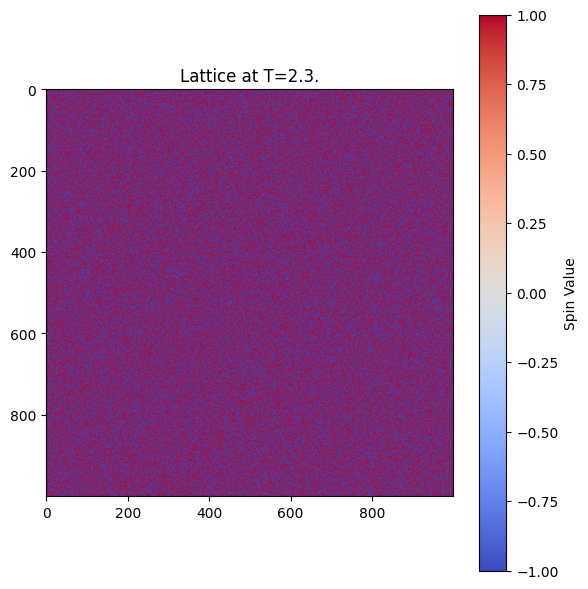

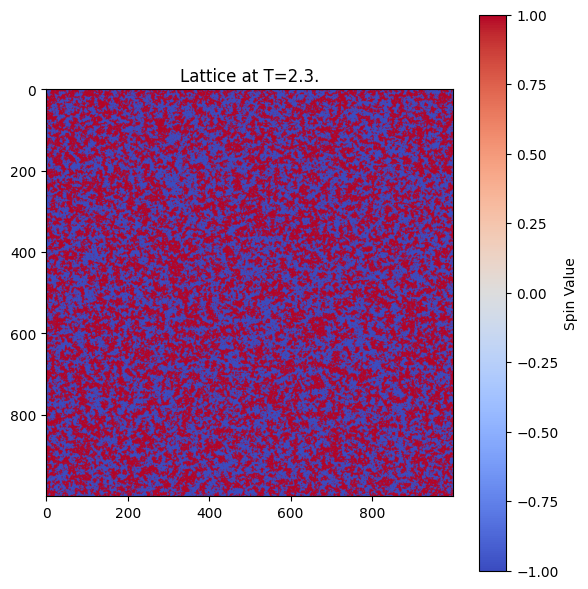

In [10]:
def generate_simple_lattice(L, temp):
  """
  Generates a simple lattice for the plot.

  Args:
    L (int):              A lattice of the plot.
    temp (float):         A current temperature of the system.

  Returns: (np.ndarray) numpy matrix.
  """
  return np.ones((L,L)) if temp < 2 else np.random.choice([-1, 1], (L,L))


def show_plot(L, data, temp):
  """
  Shows a plot for our config.

  Args:
    L (int):            A lattice of the plot.
    data (np.ndarray):  Numpy matrix of current state.
    temp (float):       A temperature.
  """
  plt.figure(figsize=(6,6))
  plt.title(f"Lattice at T={temp}.")

  plt.imshow(data, cmap='coolwarm')
  plt.colorbar(label = 'Spin Value')

  plt.tight_layout()
  plt.show()


def simulate_ising(L, temp, steps):
  """
  Creates a random lattice, runs a sim and finds the final lattice.

  Args:
    L (int):
    temp (float):
    steps (int):

  Raises:
    ValueError: If data type is mismatched.

  Returns: (np.ndarray) numpy matrix
  """
  # Validation start conditions.
  if not isinstance(L, int) or not isinstance(temp, float) or not isinstance(steps, int):
    raise ValueError("Lattice must be an int; Steps must be an int; Temperature must be a float! Aborting...")
  lattice = generate_simple_lattice(L, temp)
  show_plot(L, lattice, temp)
  lattice = fast_metropolis(lattice, temp, steps)
  show_plot(L, lattice, temp)
  return lattice


if __name__ == "__main__":
  simulate_ising(1000, 2.3, 20_000_000)

Task 2: **Build the Dataset**

Write a script to generate the training data.

    Parameters: L = 30, steps = 500,000 (enough for L=30).

    Loop 1 (Cold): Generate 50 lattices at T=1.0. Store them in a list.

    Loop 2 (Hot): Generate 50 lattices at T=3.5. Store them in a list.

    Formatting:

        Convert lists to Numpy Arrays.

        Create labels: 50 zeros and 50 ones.

        Concatenate them so you have X_data of shape (100, 30, 30) and y_data of shape (100,).

    Saving: Use np.save to save them as .npy files (data_x.npy, data_y.npy).

In [26]:
def generate_simple_lattice(L, temp):
  """
  Generates a simple lattice for the plot.

  Args:
    L (int):              A lattice of the plot.
    temp (float):         A current temperature of the system.

  Returns: (np.ndarray) numpy matrix.
  """
  return np.ones((L,L)) if temp < 2 else np.random.choice([-1, 1], (L,L))


def show_plot(L, data, temp):
  """
  Shows a plot for our config.

  Args:
    L (int):            A lattice of the plot.
    data (np.ndarray):  Numpy matrix of current state.
    temp (float):       A temperature.
  """
  plt.figure(figsize=(6,6))
  plt.title(f"Lattice at T={temp}.")

  plt.imshow(data, cmap='coolwarm')
  plt.colorbar(label = 'Spin Value')

  plt.tight_layout()
  plt.show()


def simulate_ising(L, temp, steps):
  """
  Creates a random lattice, runs a sim and finds the final lattice.

  Args:
    L (int):
    temp (float):
    steps (int):

  Raises:
    ValueError: If data type is mismatched.

  Returns: (np.ndarray) numpy matrix
  """
  # Validation start conditions.
  if not isinstance(L, int) or not isinstance(temp, float) or not isinstance(steps, int):
    raise ValueError("Lattice must be an int; Steps must be an int; Temperature must be a float! Aborting...")
  lattice = generate_simple_lattice(L, temp)
  # show_plot(L, lattice, temp)
  lattice = fast_metropolis(lattice, temp, steps)
  # show_plot(L, lattice, temp)
  return lattice


def create_and_save_dataset(L, steps, num_samples_per_class=50):
    """
    Generates dataset and saves it to .npy files.

    Args:
      L (int):
      steps (int):
      num_samples_per_class (int):

    """
    print(f"Generating {num_samples_per_class} Cold samples...")
    cold_data = []
    for _ in range(num_samples_per_class):
        # T=1.0 -> Label 0
        lattice = simulate_ising(L, 1.0, steps)
        cold_data.append(lattice)

    print(f"Generating {num_samples_per_class} Hot samples...")
    hot_data = []
    for _ in range(num_samples_per_class):
        # T=3.5 -> Label 1
        lattice = simulate_ising(L, 3.5, steps)
        hot_data.append(lattice)

    # --- Formatting for ML ---

    # Convert lists to Numpy Arrays
    X_cold = np.array(cold_data) # Shape: (50, L, L)
    X_hot = np.array(hot_data)   # Shape: (50, L, L)

    # Create Labels (y)
    # 0 for Cold, 1 for Hot
    y_cold = np.zeros(num_samples_per_class) # [0, 0, ... 0]
    y_hot = np.ones(num_samples_per_class)   # [1, 1, ... 1]

    # Concatenate
    X = np.concatenate([X_cold, X_hot], axis=0) # Shape: (100, L, L)
    y = np.concatenate([y_cold, y_hot], axis=0) # Shape: (100,)

    # Save to disk (Binary format)
    print("Saving data to 'data_x.npy' and 'data_y.npy'...")
    np.save('data_x.npy', X)
    np.save('data_y.npy', y)
    print("Done! Dataset ready.")


if __name__ == "__main__":
  create_and_save_dataset(30, 500_000)

Generating 50 Cold samples...
Generating 50 Hot samples...
Saving data to 'data_x.npy' and 'data_y.npy'...
Done! Dataset ready.


Task 3 (Optional but recommended):
Plot the first sample (X_data[0]) and the last sample (X_data[99]) to ensure one looks "blocky/solid" and the other looks "noisy".

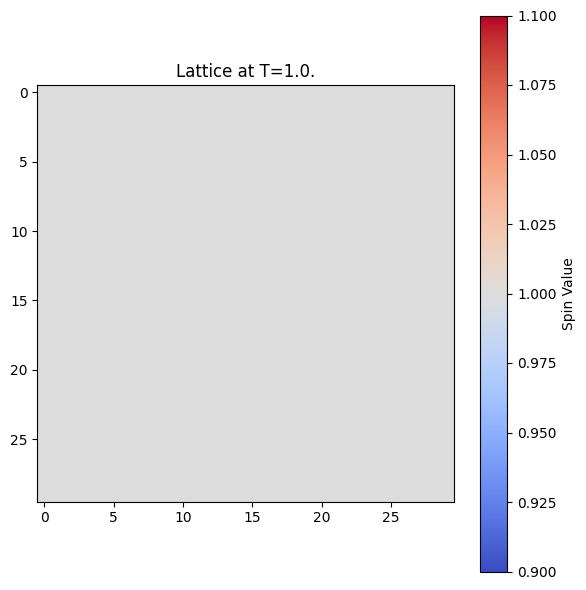

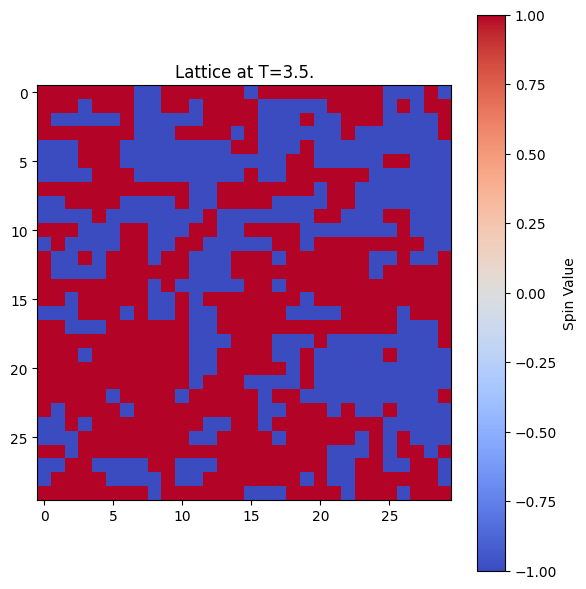

In [29]:
if __name__ == "__main__":
  data_x = np.load('data_x.npy')
  # print(data_x)
  show_plot(30, data_x[0], 1.0)
  data_y = np.load('data_y.npy')
  # print(data_y)
  show_plot(30, data_x[51], 3.5)